# Introduction

The code below uses LangChain, OpenAI, and neo4j to demonstrate the use of knowledge graphs to enhance LLM Retrieval Augmented Generation (RAG).  

The first couple chapters of Frank Herbert's 1965 novel Dune will is the source text.

The approach used will:

1. Identify entities in the RAG request. 
2. Query a graph database to find related entities and the nature of their relationships.
3. Perform a separate vector database similarity search using the request. 
4. Use the combined search results as the context for processing the RAG request.

NOTE: Much of the code for creating the LangChain pipelines below came from a blog post by Tomaz Bratanic which can be found [here](https://medium.com/neo4j/enhancing-the-accuracy-of-rag-applications-with-knowledge-graphs-ad5e2ffab663).


# Setup 

The code below imports the needed modules and does some initialization. 

In [1]:
import os
import re
from operator import itemgetter
from typing import List
import numpy as np
import pandas as pd

import nltk
from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import TokenTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from neo4j import GraphDatabase
from nltk.tokenize import word_tokenize
from yfiles_jupyter_graphs import GraphWidget

from manage_vector_db import *

load_dotenv()
nltk.download('punkt')

# Get neo4j credentials.
neo4j_url =      os.getenv("NEO4J_CONNECTION_URL")
neo4j_user =     os.getenv("NEO4J_USER")
neo4j_password = os.getenv("NEO4J_PASSWORD")

# Use neo4j credentials to set environment variables used by LangChain.
os.environ["NEO4J_URI"] =      os.environ["NEO4J_CONNECTION_URL"]
os.environ["NEO4J_USERNAME"] = os.environ["NEO4J_USER"]
os.environ["NEO4J_PASSWORD"] = os.environ["NEO4J_PASSWORD"]

def run(tx, stmt):
    """
    Method to run Cypher statements using neo4j.
    """
    result = tx.run(stmt)
    return result.consume()

def execute_write(stmt):
    """
    Method to create graph db connection and execute write Cypher statements.
    """
    driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))
    with driver.session(database="neo4j") as session:
        result_summary = session.execute_write(run, stmt)
    driver.close() 

# directly show the graph resulting from the given Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    """
    Function to use ywork graph widget to visualize 
      graph database.
    """
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

def create_docs(list_of_text: list[str]) -> list[Document]:
    """
    Utility function to create a list of LangChain documents 
      from a list of strings. 
    """
    docs = []
    for idx, chapter in enumerate(list_of_text):
        docs.append(Document(page_content=chapter, metadata={"chapter": idx+1}))
    return docs

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load, Clean, and Split Source Text

The text is loaded and cleaned. The text used can be found [here](https://raw.githubusercontent.com/ganesh-k13/shell/master/test_search/www.glozman.com/TextPages/Frank%20Herbert%20-%20Dune.txt).

In [2]:
with open('dune.txt', 'r', encoding="utf-8") as f:
    text = f.read()
# For this file, "= = = = = =" separates the chapters.
text_split = text.split('= = = = = =')
# Exclude appendicies and splits with less than 10 words.
cleaned_text = []
for idx, line in enumerate(text_split):
    if not re.search("Appendix .+:", line) and \
       not re.search('Terminology of the Imperium', line) and \
       len( word_tokenize(line.strip()) ) > 10:
       trimmed_line = line.strip()
       cleaned_text.append( trimmed_line )
# This text file contains spaces before each paragraph extra line feeds.
#  The code below cleans that up.
for idx, chapter in enumerate(cleaned_text):
    cleaned_text[idx] = chapter.replace('\n    ', '\n').replace('\n\n','\n')

# Create LangChain Document instances.
lc_docs = create_docs(cleaned_text) 

Below are some summary statistics about the documents.

# Chapters: 48
Max # words in a chapter: 12,041
Min # words: 1,250
Average # of words: 4,962
Total # of words: 238,169


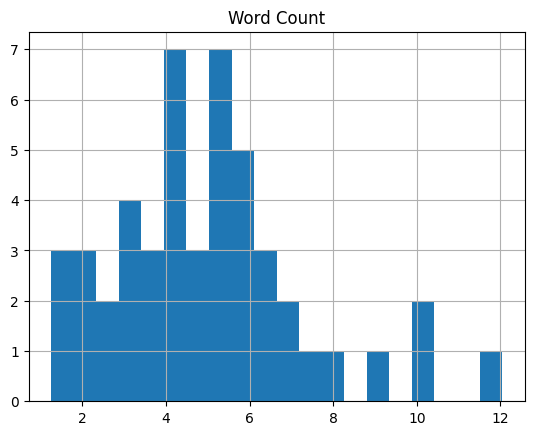

In [3]:
chpt_word_cnts = np.array([len(word_tokenize(chapter.page_content)) for chapter in lc_docs])
print(f'# Chapters: {len(chpt_word_cnts)}')
print(f'Max # words in a chapter: {chpt_word_cnts.max():,}')
print(f'Min # words: {chpt_word_cnts.min():,}')
print(f'Average # of words: {chpt_word_cnts.mean():,.0f}')
print(f'Total # of words: {chpt_word_cnts.sum():,}')
cnt_df = pd.DataFrame(data={'Word Count': chpt_word_cnts/1000})
hist = cnt_df.hist(bins=20)

Most chapters are somewhere between 4 and 6 thousands words. 

# Create a Graph Database

The LangChain wrapper for neo4j will be used to connect to a local graph database.

To limit compute time, only the first two chapters of the book will be used.

First, the database is cleared (check your neo4j instance is running) . 

In [4]:
graph = Neo4jGraph()
graph.query('MATCH (n) DETACH DELETE n')

[]

Now the graph database will be populated using LangChain and GPT 3.5 Turbo. 

The entities created will be limited to people, organizations, planets, and places. The documents will not be added to the graph database.

LangChain's `LLMGraphTransformer` will be used to populate the database. 

While experimenting, I noticed splitting the chapters into chunks of 1000 words resulted in very granular entities begin identified, e.g. `Woman`. To control that, no splitting was done. Each chapter is a document submitted for processing. This resulted in only frequently mentioned entities being included in the knowledge graph. Another approach to address this would be to pass a custom prompt to LangChain, but using chapters as documents was easier in this case.

In [5]:
%%time
llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106") 
llm_transformer = LLMGraphTransformer(llm=llm, 
                                      allowed_nodes=['Person', 'Oganization', 'Planet', 'Location'],
                                      allowed_relationships=['BORN_ON', 'MOTHER_OF', 'FATHER_OF', 
                                                             'ENEMY_OF', 'LIVES_ON', 'MENTORED', 'CHILD_OF',
                                                             'MEMBER_OF', 'RELATIVE_OF','ASSOCIATED_WITH']
                                      )
graph_documents = llm_transformer.convert_to_graph_documents(lc_docs[:2])
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=False
)

CPU times: total: 1 s
Wall time: 14.2 s


Below is a visualization of the knowledge graph created in the neo4j graph database.

In [6]:
showGraph()

GraphWidget(layout=Layout(height='670px', width='100%'))

The yFiles code above inserts a widget into the notebook which can only be viewed if the notebook is run. Below is screenshot of the widget in action.

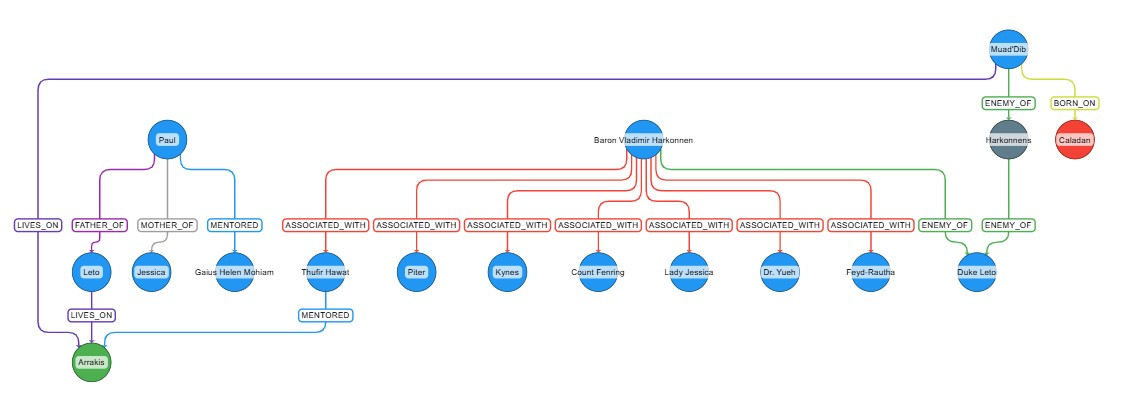

In [7]:
from IPython.display import Image
Image(filename='graph2.jpg')

This looks like a goods start for capturing the graph for the first two chapters. But there are problems. Note that the graph direction for Paul's `FATHER_OF` and `MOTHER_OF` are incorrect. This could be fixed using Cypther statements but I'll leave it to make a point later.

# Query The Knowledge Graph

## Create Graph Database Index

The code below creates an index in neo4j which will be used later for finding entiites.

In [8]:
graph = Neo4jGraph()
# Index IDs of entities labeled `__Entity__`.
graph.query("CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]");

## Create Chain to Identify Entities in a Query

In [9]:
llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106") 
# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that "
        "appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

Lets test it out.

In [10]:
dune_query = 'Who is Jessica?'
entities = entity_chain.invoke({"question": dune_query})
entities

Entities(names=['Jessica'])

## Create a Chain to Query the Knowledge Graph

The code below will use the entities identified by the `entity_chain` function (defined above) to search for the entity-relationship-entity triplets in the knowledge graph. 

In [11]:

def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

Lets give it a try.

In [12]:
print(structured_retriever(dune_query))

Paul - MOTHER_OF -> Jessica
Baron Vladimir Harkonnen - ASSOCIATED_WITH -> Lady Jessica


# Create a Vector Database

LangChain's graph utilities can be used to add source document embedding to the graph database. I decided to keep that out of the knowledge graph due to the large documents used to create the knowledge graph. Therefore, the same source text is used to create the vector database but each chapter is split into 200 token chunks. This should make the similarity search results more relevant to the RAG request.

In [13]:
splitter = TokenTextSplitter(encoding_name='gpt2', chunk_size=200, chunk_overlap=10)
chpt_1_2_docs = splitter.split_documents(lc_docs[:2])
print(f'# of document chunks: {len(chpt_1_2_docs)}')

# of document chunks: 58


A FAISS vector database is created using a utility function I wrote in the `manage_vector_db.py` script.

In [14]:
vector_db = create_vector_db(chpt_1_2_docs)

The `create_vector_db` method returns a LangChain FAISS object which will be used to query the unstructured data.

In [15]:
def unstructured_search(_query, _num_docs=5, _num_docs_fetch=20):
    doc_results = vector_db.similarity_search_with_score(
        dune_query,
        k=_num_docs,
        fetch_k=_num_docs_fetch,
        distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE,
    )
    return '\n\n'.join([doc[0].page_content for doc in doc_results])

Time to test.

In [16]:
print(unstructured_search(dune_query,2,5))

. She blamed it on space travel and association with that abominable Spacing Guild and its secretive ways. But here was a mission that required personal attention from a Bene Gesserit-with-the-Sight. Even the Padishah Emperor's Truthsayer couldn't evade that responsibility when the duty call came.
Damn that Jessica! the Reverend Mother thought. If only she 'd borne us a girl as she was ordered to do!
Jessica stopped three paces from the chair, dropped a small curtsy, a gentle flick of left hand along the line of her skirt. Paul gave the short bow his dancing master had taught -- the one used "when in doubt of another's station."
The nuances of Paul's greeting were not lost on the Reverend Mother. She said: "He's a cautious one, Jessica." 
Jessica's hand went to Paul's shoulder, tightened there. For a heartbeat, fear pulsed through her palm. Then she had

. "Your Reverence, I --" 
"Jessica, you know it must be done." 
Paul looked up at his mother, puzzled. 
Jessica straightened. "Yes . 

# A Graph RAG Search

Its time to combine the two context sources: the unstructured vector similarity search results and the structured knowlege graph search results.

## Create A Context Retriever

First, the `retriever` method below will combine the results of a structured and unstructured context search.

In [17]:
def retriever(input):
    """
    Create the context to be used for a Graph RAG search.
    """
    question =  input['question']
    use_unstr = input.get('use_unstr', True)
    use_kg =    input.get('use_kg', True)
    
    structured_data = structured_retriever(question)    if use_kg else ''
    unstructured_data = unstructured_search(question,3) if use_unstr else ''
    final_data = f'Structured data: \n{structured_data}\n\nUnstructured data: \n{unstructured_data}'
    return final_data

Lets test it.

In [18]:
context = retriever({'question': dune_query})
print(context)

Structured data: 
Paul - MOTHER_OF -> Jessica
Baron Vladimir Harkonnen - ASSOCIATED_WITH -> Lady Jessica

Unstructured data: 
. She blamed it on space travel and association with that abominable Spacing Guild and its secretive ways. But here was a mission that required personal attention from a Bene Gesserit-with-the-Sight. Even the Padishah Emperor's Truthsayer couldn't evade that responsibility when the duty call came.
Damn that Jessica! the Reverend Mother thought. If only she 'd borne us a girl as she was ordered to do!
Jessica stopped three paces from the chair, dropped a small curtsy, a gentle flick of left hand along the line of her skirt. Paul gave the short bow his dancing master had taught -- the one used "when in doubt of another's station."
The nuances of Paul's greeting were not lost on the Reverend Mother. She said: "He's a cautious one, Jessica." 
Jessica's hand went to Paul's shoulder, tightened there. For a heartbeat, fear pulsed through her palm. Then she had

. "Your

## Create Graph RAG Chain 

The code below creates a RAG pipline that combines the unstructured vector similarity and the knowlege graph results.

In [19]:
from langchain.globals import set_debug
set_debug(False)

def print_me(inputs):
    print(f'Inputs: {inputs}')
    return inputs

template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = PromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106") #gpt-3.5-turbo-1106 gpt-4o

chain = prompt | llm | StrOutputParser()

chain = (RunnableLambda(print_me) |
         RunnableParallel(
             {
                 "context": retriever,
                 "question": itemgetter("question")
             }
    )
    | prompt
    | llm
    | StrOutputParser()
)

def compare_context(_query):
    """
    Compare using unstructured and knowlege graph sources.
    """
    print('#1 ---')
    print( chain.invoke({"question": _query, "use_unstr": True,  "use_kg": True}) )
    print('#2 ---')
    print( chain.invoke({"question": _query, "use_unstr": False, "use_kg": True}) )
    print('#3 ---')
    print( chain.invoke({"question": _query, "use_unstr": True,  "use_kg": False}) )

In [20]:
compare_context(dune_query)

#1 ---
Inputs: {'question': 'Who is Jessica?', 'use_unstr': True, 'use_kg': True}
Jessica is the mother of Paul and an important figure in the story.
#2 ---
Inputs: {'question': 'Who is Jessica?', 'use_unstr': False, 'use_kg': True}
Jessica is the daughter of Paul's mother and is associated with Baron Vladimir Harkonnen.
#3 ---
Inputs: {'question': 'Who is Jessica?', 'use_unstr': True, 'use_kg': False}
Jessica is a character in the text.


Notice the different results. The first RAG request uses both the unstructured similarity and knowledge graph search results. The second RAG request only uses the graph relationships. The LLM in the second request is more informative. This is probably because its easier to describe someone by their relationships to others. More nuanced questions would probably do a better job of utilizing both context sources. The last request which only uses the unstructured context was the least informative. 

What's also interesting is that the second request expressed the incorrect family relationship discussed above when the graph database was populated. This not only shows that knowledge graphs created using these techniques need domain expert review, but also that the unstructured context can be used to fix incorrect relationships in the graph at request time.

# Conclusion

The results provide evidence of the benefits of enhancing RAG requests with knowledge graphs. A knowledge graph can not only supplement the unstructured context, but the unstructured context can improve knowledge graph only results.